In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import scipy.integrate

import numpy as np

import matplotlib.pyplot as plt

import math

import random

from mpmath import polylog

from sklearn.model_selection import train_test_split

import time

In [36]:
def generate_data(func, lower, upper, params=[], n_samples=100, n_dim=1):
    """
    Generates data in the form of a 2D (1D in case the function 
    is single-variable) tensor of variables for the function and neural network input
    as well as the function values for the generated tensor of variables.

    @param func      function to provide values for the variables
    @param lower     lower bounds of variables (list, tensor or scalar)
    @param upper     upper bounds of variables (list, tensor or scalar)
    @param n_samples number of points of data to generate
                     (default value is 100)
    @param n_dim     number of dimensions of the function func
                     (default value is 1)

    @returns         variables x and function values y
    """
    X_list = [torch.linspace(lower[n], upper[n], n_samples).view(n_samples, 1) for n in range(n_dim)]
    X = torch.cat(X_list, dim=1)
    
    y = func(X).view(n_samples, 1)
    
    return X, y

In [37]:
class MLP(nn.Module):
    """
        Нейросеть, которая будет обучаться приближать функцию одной переменной.
        
        Нейросеть имеет архитектуру:

        Входной слой (1 нейрон для переменной функции + смещение, линейная функция активации)
        Скрытый слой (произвольное количество нейронов + смещение, функция активации - сигмоида)
        Выходной слой (1 нейрон для приближенного значения функции, линейная функция активации)
    """
    def __init__(self, input_size, hidden_size):
        """
            Конструктор для нейросети.
            @param self        нейросеть (необходим для включения в класс)
            @param hidden_size размер скрытого слоя (размеры входного и выходного слоёв равны одному
                               в рамках данной задачи, так как у функции одна переменная и 
                               задача сводится к описанию функции, то есть числа, скаляра).
        """
        super(MLP, self).__init__()
        self.input_hidden_layer = nn.Linear(input_size, hidden_size) # инициализация входного и скрытого слоя, 
                                                     # размеры: 1 --> размер скрытого слоя
        self.sigmoid_activation = nn.Sigmoid() # инициализация функции активации скрытого слоя
        self.output_layer = nn.Linear(hidden_size, 1) # инициализация выходного слоя, 
                                                      # размеры: размер скрытого слоя --> 1
    
    def forward(self, x):
        """
            Функция распространения данных через нейросеть вперёд.
           
            @param self   нейросеть (необходим для включения в класс)
            @param x      данные
           
            @returns выход в выходном нейроне
        """
        x = self.input_hidden_layer(x) # данные прошли входной слой и аккумулирвоаны в скрытом слое
        x = self.sigmoid_activation(x) # данные прошли функцию активации скрытого слоя
        x = self.output_layer(x) # данные прошли выходной слой
        
        return x


def train_model(model, criterion, optimizer, x_train, y_train, epochs, verbose=True):
    """
        Trains the model.
        
        @param model        The model to be trained
        @param criterion    Loss function
        @param optimizer    Optimization algorithm
        @param x_train      Training inputs
        @param y_train      True labels
        @param epochs       Number of training epochs
    """
    loss_history = [] # история обучения (изменения функции потерь)
    start_time = time.time()
    for epoch in range(epochs):
        predictions = model(x_train) # все переменные проводятся через нейросеть 
                                     # и формируются предскзания значений функции
        loss = criterion(predictions, y_train) # вычисляется функция потерь на данной эпохе

        optimizer.zero_grad() # обнуляются градиенты перед обратным распространением ошибки
        loss.backward() # обратное распространение ошибки
        optimizer.step() # шаг оптимизации - обновление параметров модели 

        loss_history.append(loss.item()) # запись текущей функции потерь

        if verbose:
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.10f}') # вывод информации об обучении
    total_time = time.time() - start_time  # Общее время обучения
    print(f'Training done! Time elapsed: {total_time:.2f} seconds')
    return loss_history # возвращается история обучения


def test_model(model, criterion, x_test, y_test):
    """
        Tests the model.
        
        @param model        The trained model
        @param criterion    Loss function
        @param x_test       Test inputs
        @param y_test       True labels
    """
    with torch.no_grad():  # отключение расчета градиентов 
                           # (расчет градиентов может происходить по умолчанию 
                           # даже без использования их потом, что излишне нагружает память)
        predictions = model(x_test)  # тестовые переменные проводятся через обученную модель
        loss = criterion(predictions, y_test)  # вычисляется функция потерь для тестового набора

    # Возвращаем вычисленную функцию потерь
    return loss.item()  # Возвращаем скалярное значение ошибки


def predict_with_model(model, x_test):
    """
        Uses the model to predict values based on x_test arguments.
    
        @param model        The trained model
        @param x_test       Test inputs
    """
    with torch.no_grad():
        predictions = model(x_test)

    return predictions


def extract_model_params(model):
    """
        Функция извлечения параметров нейросети.
        @param model модель, из которой необходимо извлеч параметры
        @returns 4 объекта типа numpy.array: смещения 1-го слоя, веса 1-го слоя,
                 смещения 2-го слоя, веса 2-го слоя
    """
    # detach() - возвращает выбранный параметр, numpy() конвертирует в формат numpy.array,
    # flatten() для весов преобразует векторы-столбцы в векторы-строки.
    b1 = model.input_hidden_layer.bias.detach().numpy() 
    w1 = model.input_hidden_layer.weight.detach().numpy().flatten()
    b2 = model.output_layer.bias.detach().numpy() 
    w2 = model.output_layer.weight.detach().numpy().flatten()
    
    return b1, w1, b2, w2

# Integration function

In [38]:
def get_NN_integral(alpha, beta, b1, w1, b2, w2):
    """
        Функция, реализующая метод численного интегрирования функции одной переменной
        на основе параметров нейросети. Реализует формулы (6.1) и (6.2).

        @param alpha нижняя граница интегрирования
        @param beta  верхняя граница интегрирования
        @param b1    смещения между входным и скрытым слоями
        @param w1    веса между входным и скрытым слоями
        @param b2    смещения между скрытым и выходным слоями
        @param w2    веса между скрытым и выходным слоями

        @returns численный интеграл на основе параметров нейросети.
    """
    def Phi_j(alpha, beta, b1_j, w1_j):
        """
            Вложенная функция, реализующая разность полилогарифмов (6.2).

            @param alpha нижняя граница интегрирования
            @param beta  верхняя граница интегрирования
            @param b1_j  j-е смещение между входным и скрытым слоями
            @param w1_j  j-тый вес между входным и скрытым слоями

            @returns разность полилогарифмов (6.2)
        """
        term_alpha = polylog(1, -np.exp(-b1_j - w1_j * alpha)) # расчет первого полилогарифма 1-го порядка
        term_beta = polylog(1, -np.exp(-b1_j - w1_j * beta)) # расчет второго полилогарифма 1-го порядка
        
        return term_alpha - term_beta # результат - разность первого и второго полилогарифмов

    integral_sum = 0 # сумма интеграллов 
    
    for w2_j, w1_j, b1_j in zip(w2, w1, b1):
        phi_j = Phi_j(alpha, beta, b1_j, w1_j) # рассчет разности полилогарифмов (6.2)
        integral_sum += w2_j * ((beta - alpha) + phi_j / w1_j) # аккумулирование интегралла для суммы в (6.1)
    
    return b2 * (beta - alpha) + integral_sum # результат полная формула численног метода (6.1)

# Oscillatory 1D

In [39]:
def osc_1d(X):
    return torch.cos(2 * math.pi * u + X * c)

def osc_1d_float(X):
    return math.cos(2 * math.pi * u + X * c)

In [40]:
input_size = 1
hidden_size = 100
learning_rate = 0.001
num_epochs = 5000

a = 0.0
b = 1.0

In [41]:
u = random.uniform(0, 1)
cs = random.uniform(0, 1)
c = cs

In [42]:
X, y = generate_data(osc_1d, params=[u,c], lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

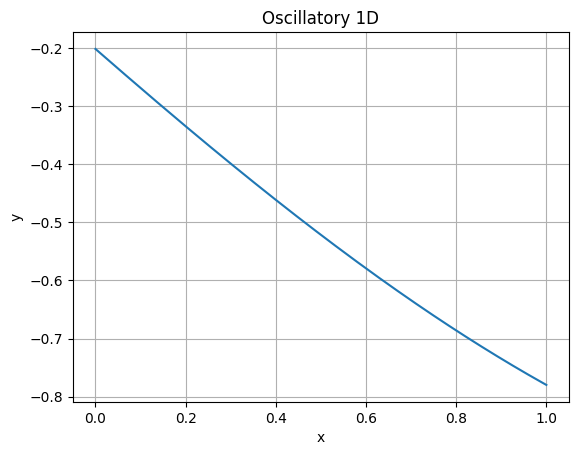

In [43]:
x_np = X[:, 0].numpy()
y_np = y.numpy()
plt.plot(x_np, y_np)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Oscillatory 1D')
plt.grid(True)
plt.show()

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Model

### Hyperparams for the NN model

In [45]:
input_size = 1
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### Model definition, compilation and training

In [46]:
model = MLP(input_size, hidden_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs)

Epoch [100/5000], Loss: 0.0713139847
Epoch [200/5000], Loss: 0.0250952896
Epoch [300/5000], Loss: 0.0234501734
Epoch [400/5000], Loss: 0.0221889522
Epoch [500/5000], Loss: 0.0208325051
Epoch [600/5000], Loss: 0.0194072891
Epoch [700/5000], Loss: 0.0179308802
Epoch [800/5000], Loss: 0.0164158028
Epoch [900/5000], Loss: 0.0148726944
Epoch [1000/5000], Loss: 0.0133127859
Epoch [1100/5000], Loss: 0.0117498059
Epoch [1200/5000], Loss: 0.0102013871
Epoch [1300/5000], Loss: 0.0086896587
Epoch [1400/5000], Loss: 0.0072408686
Epoch [1500/5000], Loss: 0.0058838520
Epoch [1600/5000], Loss: 0.0046473453
Epoch [1700/5000], Loss: 0.0035564457
Epoch [1800/5000], Loss: 0.0026289076
Epoch [1900/5000], Loss: 0.0018721803
Epoch [2000/5000], Loss: 0.0012820989
Epoch [2100/5000], Loss: 0.0008437456
Epoch [2200/5000], Loss: 0.0005343056
Epoch [2300/5000], Loss: 0.0003270835
Epoch [2400/5000], Loss: 0.0001955562
Epoch [2500/5000], Loss: 0.0001164420
Epoch [2600/5000], Loss: 0.0000713246
Epoch [2700/5000], Lo

In [47]:
summary(model, (input_size,)) # (input_size, ) - input shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              20
           Sigmoid-2                   [-1, 10]               0
            Linear-3                    [-1, 1]              11
Total params: 31
Trainable params: 31
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


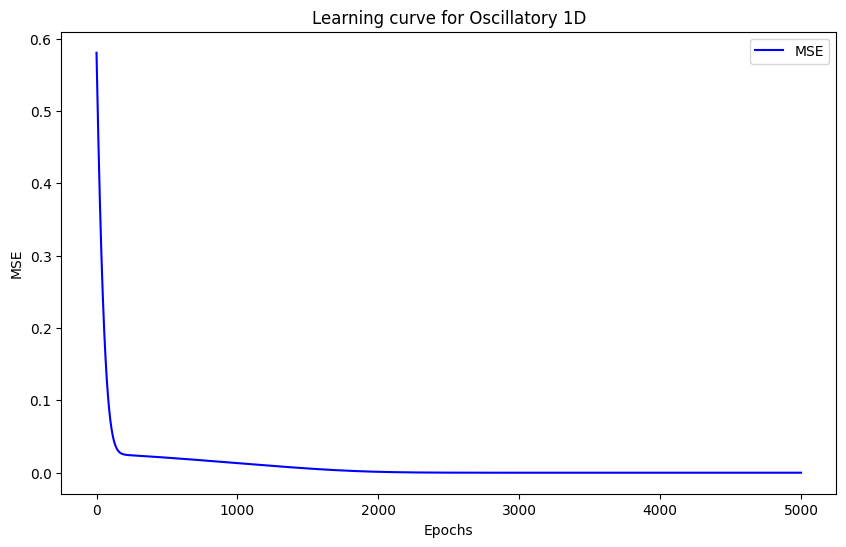

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for Oscillatory 1D')
plt.legend()
plt.grid(False)
plt.show()

### Model testing

In [49]:
test_loss = test_model(model, criterion, x_test, y_test)
print(f"Test Loss: {test_loss:.10f}")

Test Loss: 0.0000180036


In [50]:
bs1, we1, bs2, we2 = extract_model_params(model)

In [51]:
a = 0.0
b = 1.0

In [52]:
nni = get_NN_integral(a, b, bs1, we1, bs2, we2)

nni

array([mpf('-0.51120269358207682')], dtype=object)

In [53]:
result, error = scipy.integrate.quad(osc_1d_float, a, b)

print("Integral:", result)
print("Error:", error)

Integral: -0.5111778981411214
Error: 5.6752147219576594e-15


In [ ]:
abs(float(nni[0]) - result)

In [62]:
def test_osc_1d(iteration_index: int, h: float):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0, 1)
    c = h # / cs
    
    def osc_1d(X):
        return torch.cos(2 * math.pi * u + X * c)

    def osc_1d_float(X):
        return math.cos(2 * math.pi * u + X * c)
  
    X, y = generate_data(osc_1d, params=[u, c], lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Oscillatory 1D")
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(osc_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = osc_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

Iteration 1 is running!


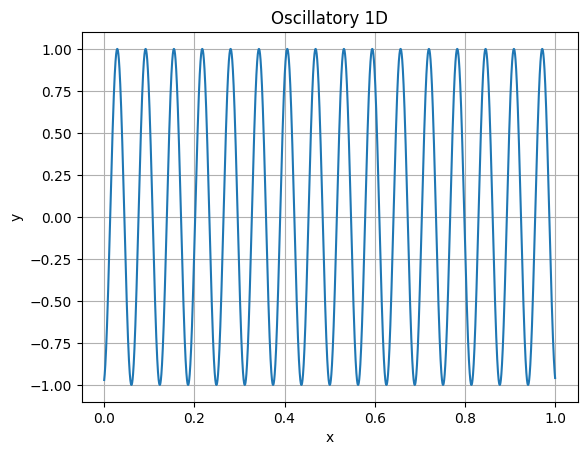

Training done! Time elapsed: 5.75 seconds
Test Loss: 0.5017426014
0.005246129
Iteration 2 is running!


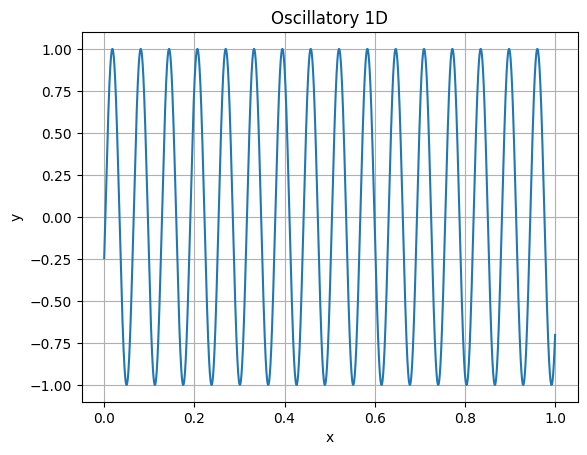

Training done! Time elapsed: 5.71 seconds
Test Loss: 0.5052782297
0.0025766436
Iteration 3 is running!


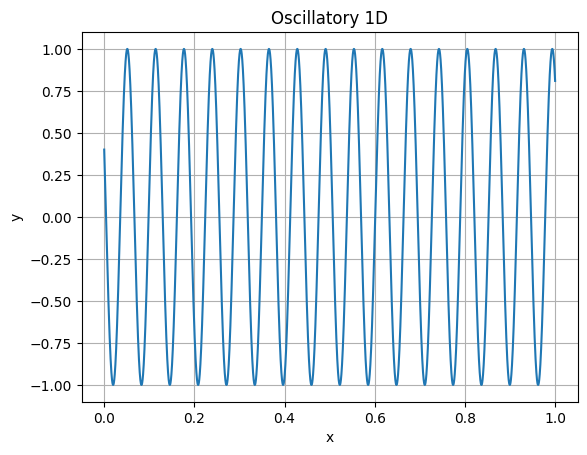

Training done! Time elapsed: 5.76 seconds
Test Loss: 0.4982105494
-0.0032909345
Iteration 4 is running!


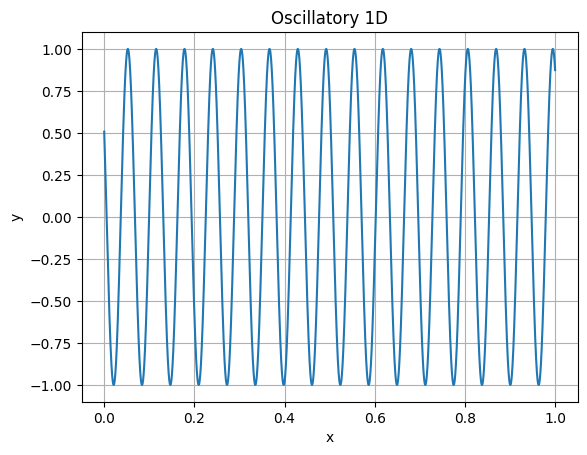

Training done! Time elapsed: 6.03 seconds
Test Loss: 0.4949985743
-0.0037564468
Iteration 5 is running!


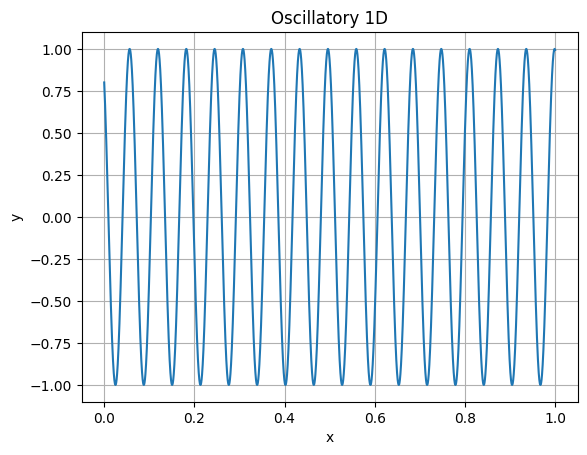

Training done! Time elapsed: 5.87 seconds
Test Loss: 0.5130029917
-0.0048784865
Iteration 6 is running!


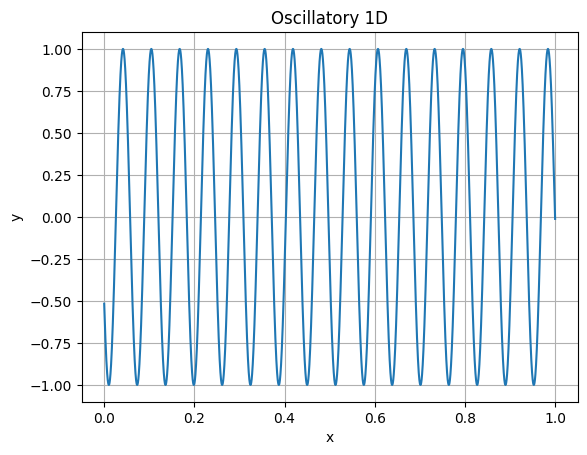

Training done! Time elapsed: 6.09 seconds
Test Loss: 0.4845208824
0.0014365306
Iteration 7 is running!


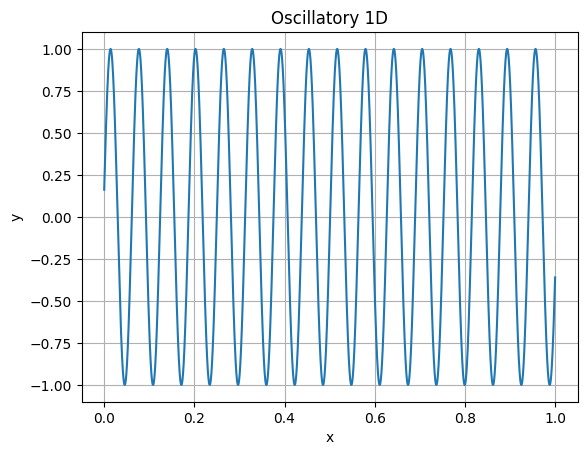

Training done! Time elapsed: 5.71 seconds
Test Loss: 0.4888673723
0.0005392488
Iteration 8 is running!


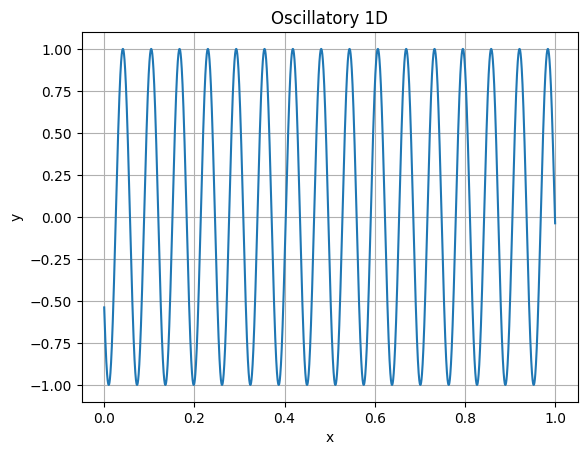

Training done! Time elapsed: 5.84 seconds
Test Loss: 0.4894627631
0.0015672976
Iteration 9 is running!


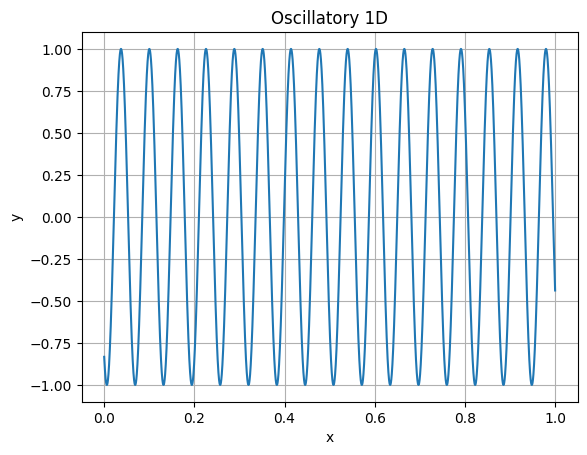

Training done! Time elapsed: 6.02 seconds
Test Loss: 0.4873646498
0.0034546023
Iteration 10 is running!


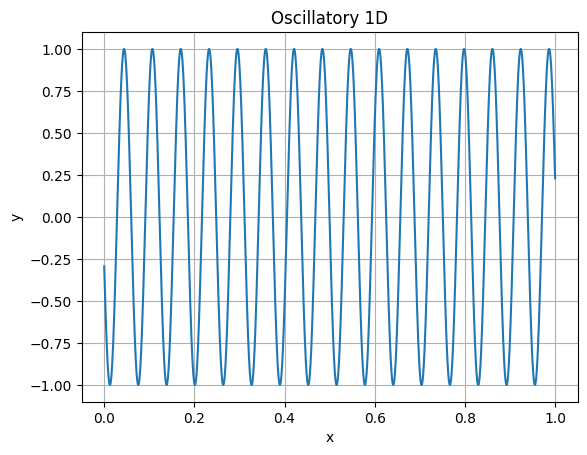

Training done! Time elapsed: 6.33 seconds
Test Loss: 0.5070285797
0.0001750905


In [63]:
results = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results.append(test_osc_1d(i, h=100))

In [65]:
def plot_test_results(results: list):
    x_values = [i for i, _ in enumerate(results)]  # Index as x-axis
    nnis = [v1 for v1, v2, v3 in results]
    quads = [v2 for v1, v2, v3 in results]
    trapz = [v3 for v1, v2, v3 in results]
    abs_err_quad = [abs(v1 - v2) for v1, v2, v3 in results]
    abs_err_trapz = [abs(v1 - v3) for v1, v2, v3 in results]
    
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 5))
    
    ax1.plot(x_values, nnis, label='nnis', marker='o')
    ax1.plot(x_values, quads, label='quads', marker='x')
    ax1.plot(x_values, trapz, label='trapz', marker='s')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Integrals')
    ax1.set_title('Numerical integral values')
    ax1.legend()
    
    ax2.plot(x_values, abs_err_quad, label='|nnis - quads|', marker='s', color='red')
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Absolute error')
    ax2.set_title('NN and quad method')
    ax2.legend()
    
    ax3.plot(x_values, abs_err_trapz, label='|nnis - trapz|', marker='o', color='red')
    ax3.set_xlabel('Index')
    ax3.set_ylabel('Absolute error')
    ax3.set_title('NN and trapezoidal method')
    ax3.legend()
    
    ax4.plot(x_values, nnis, label='nnis', marker='o')
    ax4.set_xlabel('Index')
    ax4.set_ylabel('NNIs')
    ax4.set_title('NN integrals')
    ax4.legend()
    
    ax5.plot(x_values, quads, label='quads', marker='x', color='y')
    ax5.set_xlabel('Index')
    ax5.set_ylabel('QUADs')
    ax5.set_title('QUAD integrals')
    ax5.legend()
    
    ax6.plot(x_values, trapz, label='trapz', marker='s', color='g')
    ax6.set_xlabel('Index')
    ax6.set_ylabel('TRAPZ')
    ax6.set_title('Trapezoid integrals')
    ax6.legend()
    
    plt.tight_layout()
    plt.show()

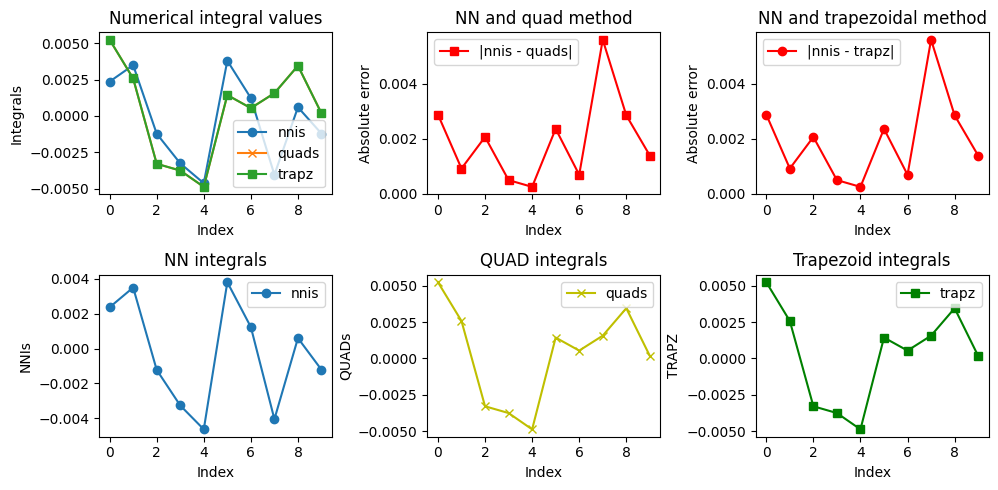

In [66]:
plot_test_results(results)

# Product peak 1D

In [67]:
def test_prod_peek_1d(index, h):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0, 1)
    c = h # / cs

    def osc_1d(X):
        return 1 / (c**(-2) + (X - u)**2)

    def osc_1d_float(X):
        return 1 / (c**(-2) + (X - u)**2)
  
    X, y = generate_data(osc_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Product peek 1D')
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(osc_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = osc_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

Iteration 1 is running!


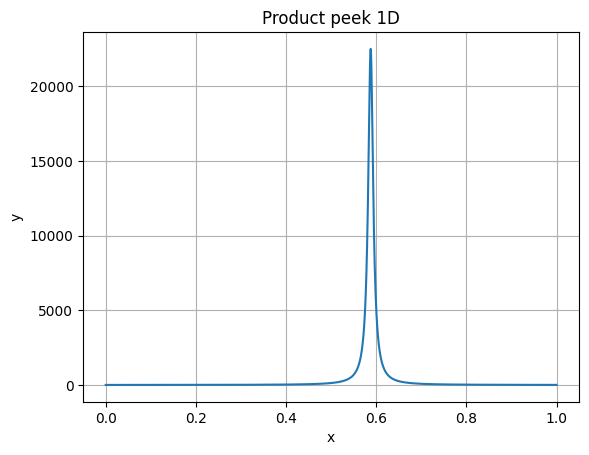

Training done! Time elapsed: 5.96 seconds
Test Loss: 3729807.0000000000
467.11237
Iteration 2 is running!


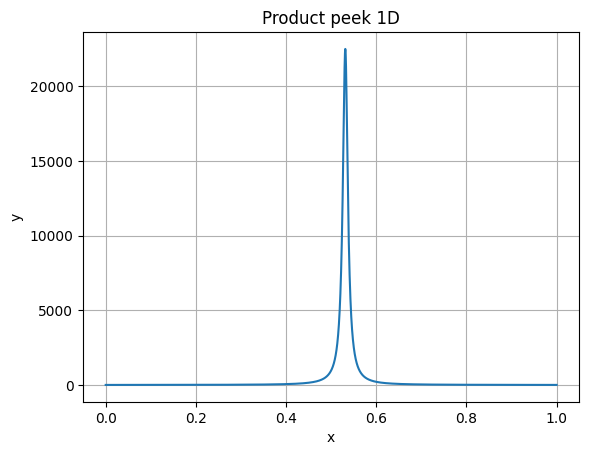

Training done! Time elapsed: 6.18 seconds
Test Loss: 6447847.0000000000
467.22336
Iteration 3 is running!


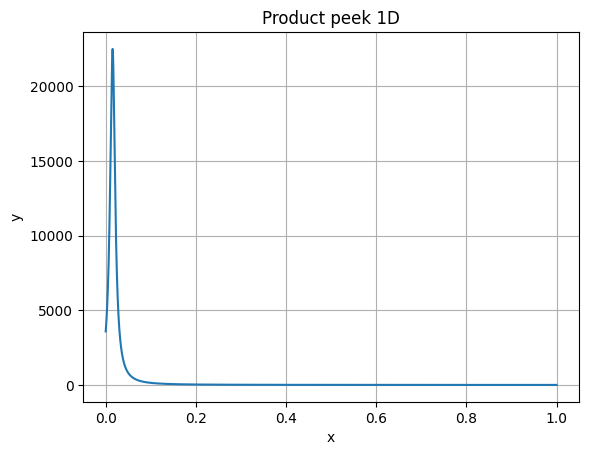

Training done! Time elapsed: 5.52 seconds
Test Loss: 4716755.0000000000
408.64374
Iteration 4 is running!


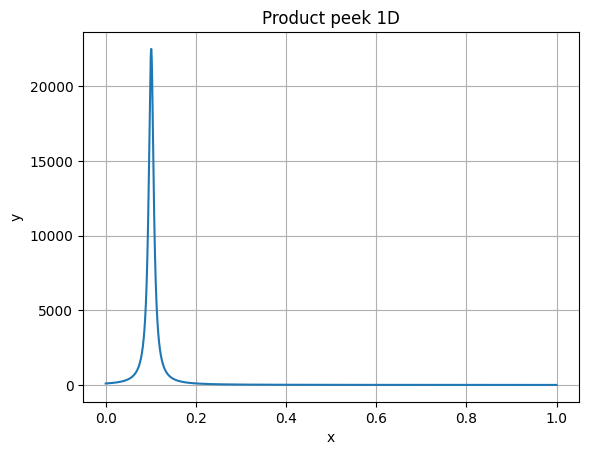

Training done! Time elapsed: 6.03 seconds
Test Loss: 4997226.5000000000
460.2321
Iteration 5 is running!


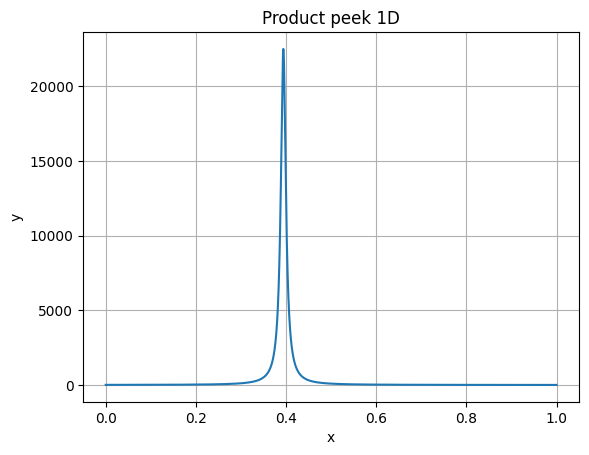

Training done! Time elapsed: 5.94 seconds
Test Loss: 5924933.5000000000
467.0508
Iteration 6 is running!


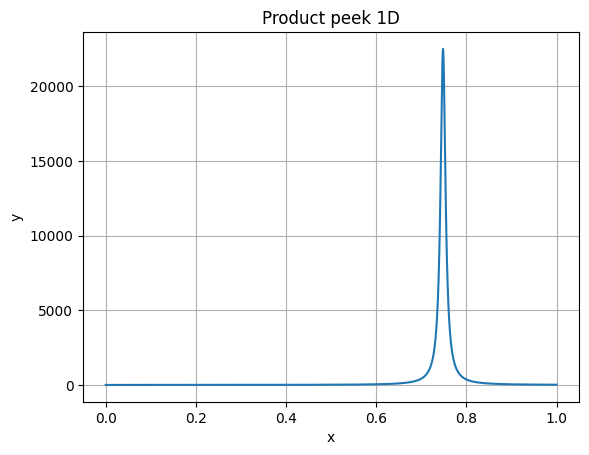

Training done! Time elapsed: 5.79 seconds
Test Loss: 3869823.0000000000
465.9332
Iteration 7 is running!


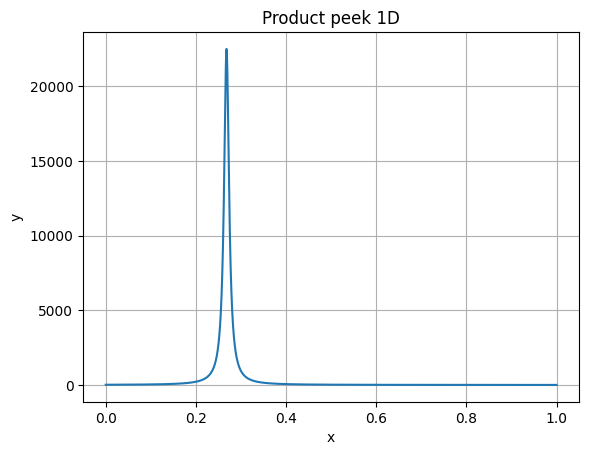

Training done! Time elapsed: 5.50 seconds
Test Loss: 5611457.5000000000
466.1423
Iteration 8 is running!


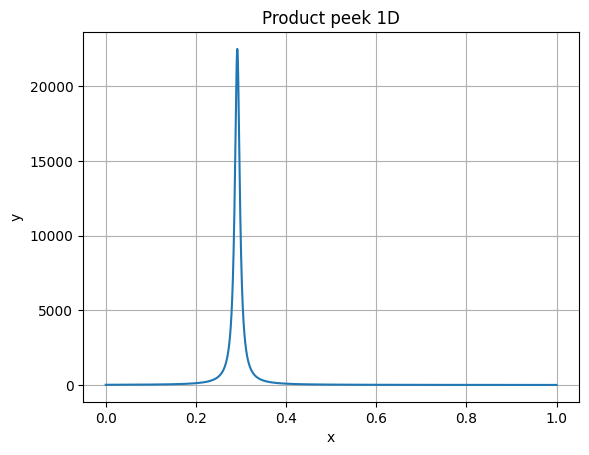

Training done! Time elapsed: 5.79 seconds
Test Loss: 5531977.0000000000
466.4012
Iteration 9 is running!


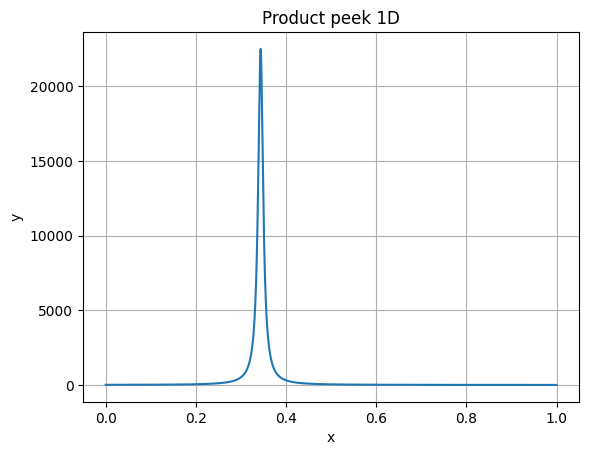

Training done! Time elapsed: 5.59 seconds
Test Loss: 5495015.5000000000
466.80527
Iteration 10 is running!


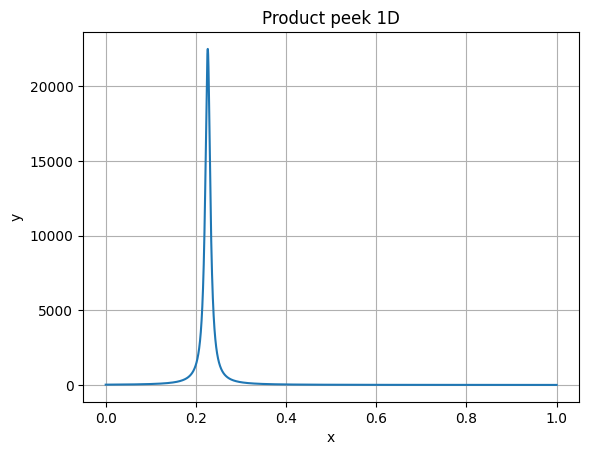

Training done! Time elapsed: 5.87 seconds
Test Loss: 4866585.0000000000
465.52942


In [68]:
results2 = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results2.append(test_prod_peek_1d(i, 150))

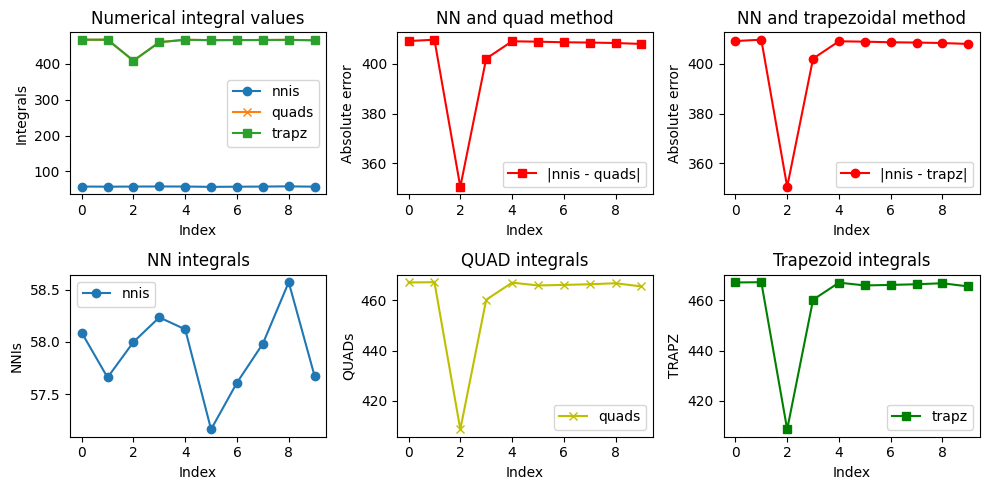

In [69]:
plot_test_results(results2)

# Corner peak 1D

In [71]:
def test_corn_peek_1d(index, h):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0.5, 1)
    c = h * cs

    def corn_peek_1d(X):
        return (1 + c * x) ** (-2)

    def corn_peek_float(X):
        return (1 + c * x) ** (-2)
  
    X, y = generate_data(osc_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Corner Peek 1D')
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(osc_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = osc_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

Iteration 1 is running!


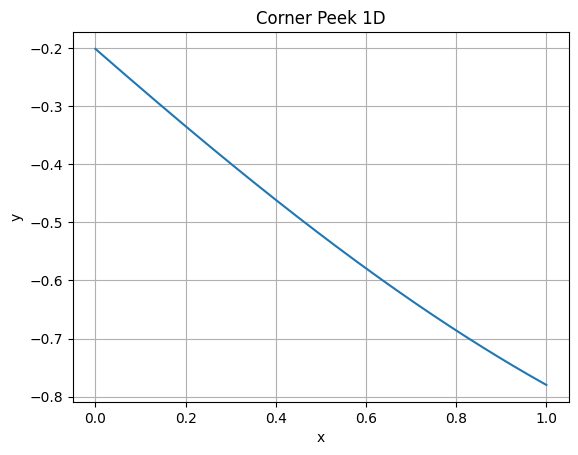

Training done! Time elapsed: 5.49 seconds
Test Loss: 0.0000002064
-0.51117784
Iteration 2 is running!


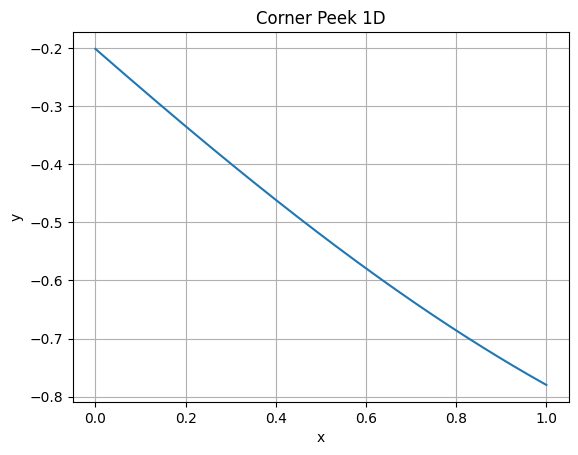

Training done! Time elapsed: 5.65 seconds
Test Loss: 0.0000177060
-0.51117784
Iteration 3 is running!


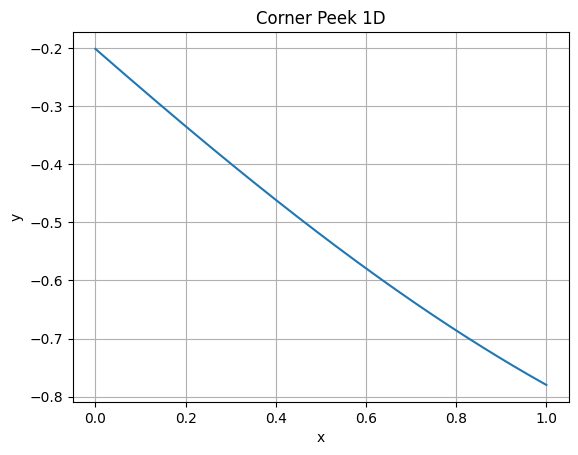

Training done! Time elapsed: 5.68 seconds
Test Loss: 0.0000002874
-0.51117784
Iteration 4 is running!


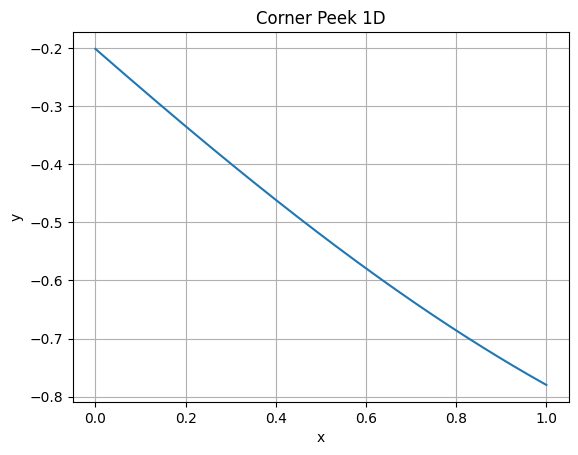

Training done! Time elapsed: 5.53 seconds
Test Loss: 0.0000093446
-0.51117784
Iteration 5 is running!


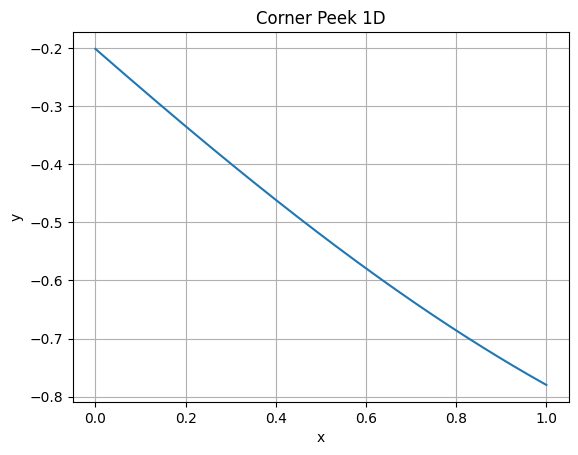

Training done! Time elapsed: 5.73 seconds
Test Loss: 0.0000087291
-0.51117784
Iteration 6 is running!


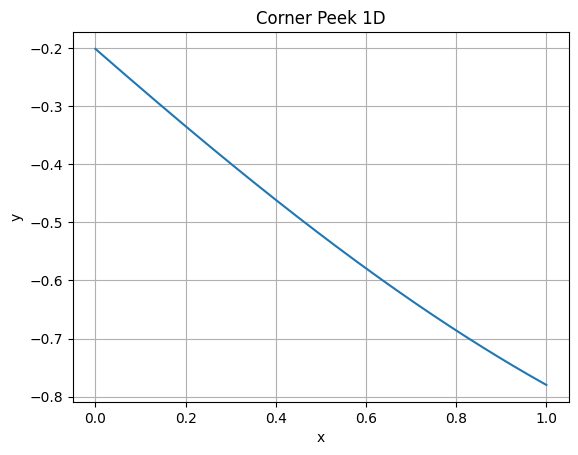

Training done! Time elapsed: 5.78 seconds
Test Loss: 0.0000000500
-0.51117784
Iteration 7 is running!


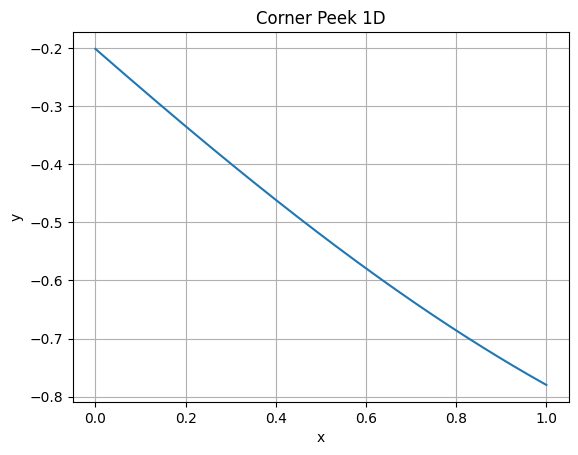

Training done! Time elapsed: 5.48 seconds
Test Loss: 0.0000037492
-0.51117784
Iteration 8 is running!


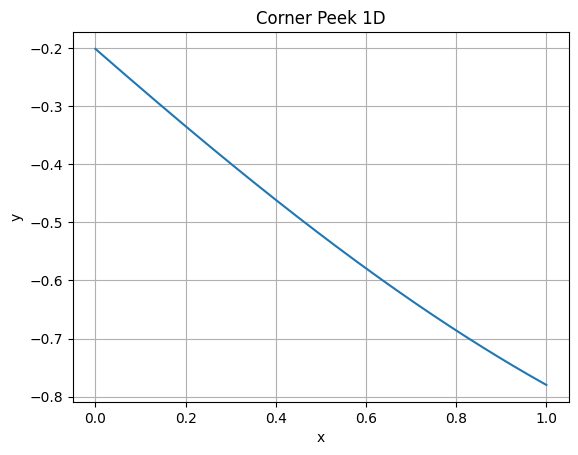

Training done! Time elapsed: 5.53 seconds
Test Loss: 0.0000014377
-0.51117784
Iteration 9 is running!


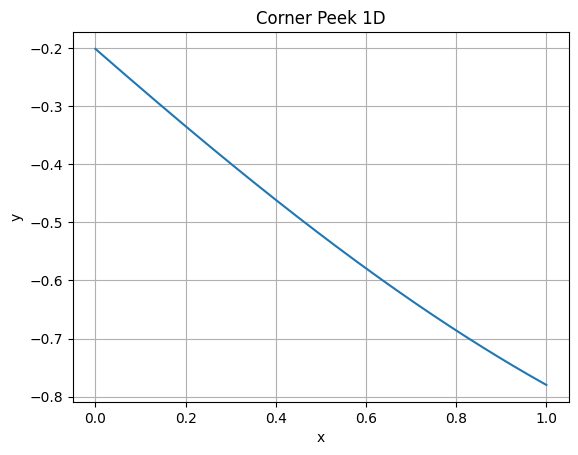

Training done! Time elapsed: 5.94 seconds
Test Loss: 0.0000023519
-0.51117784
Iteration 10 is running!


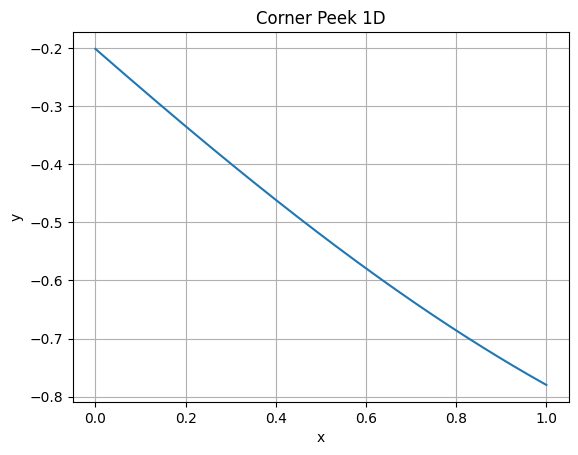

Training done! Time elapsed: 5.72 seconds
Test Loss: 0.0000097263
-0.51117784


In [72]:
results3 = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results3.append(test_corn_peek_1d(i, 600))

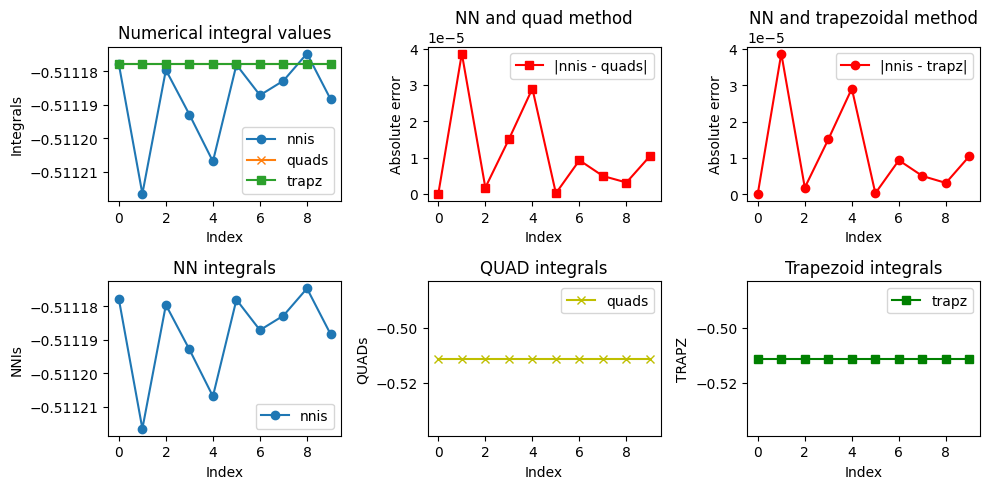

In [73]:
plot_test_results(results3)

# Gaussian 1D

In [82]:
def test_gauss_1d(index, h):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0.5, 1)
    c = h # * cs

    def gauss_1d(X):
        return torch.exp(- c**2 * (X - u)**2)

    def gauss_1d_float(X):
        return np.exp(- c**2 * (X - u)**2)
  
    X, y = generate_data(gauss_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Gaussian 1D')
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(gauss_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = osc_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

Iteration 1 is running!


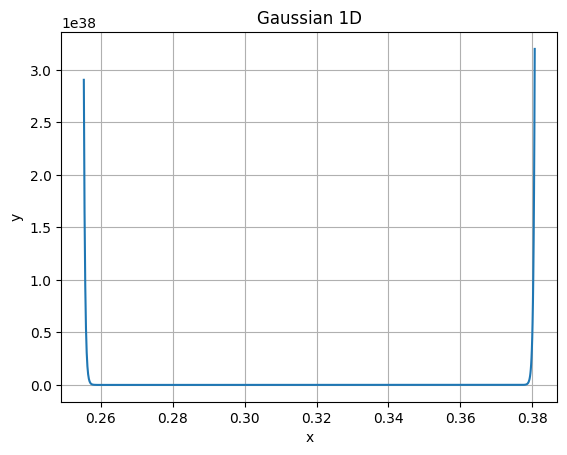

Training done! Time elapsed: 5.10 seconds
Test Loss: nan
-0.51117784
Iteration 2 is running!


/var/folders/df/v02b0vfx2tbc5plrdx4v6gk80000gn/T/ipykernel_64473/1100295898.py:11: RuntimeWarning: overflow encountered in exp
  return np.exp(c**2 * (X - u)**2)
/var/folders/df/v02b0vfx2tbc5plrdx4v6gk80000gn/T/ipykernel_64473/1100295898.py:40: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result_quad, _ = scipy.integrate.quad(gauss_float, a, b)


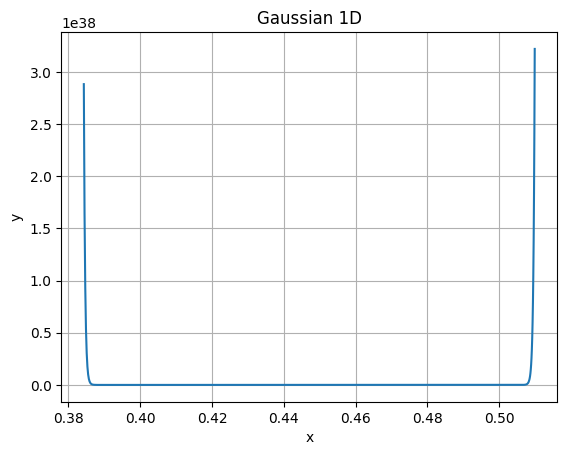

Training done! Time elapsed: 5.07 seconds
Test Loss: nan
-0.51117784
Iteration 3 is running!


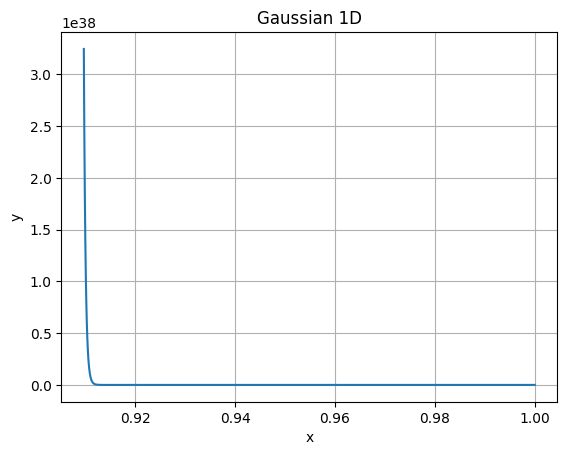

Training done! Time elapsed: 4.98 seconds
Test Loss: nan
-0.51117784
Iteration 4 is running!


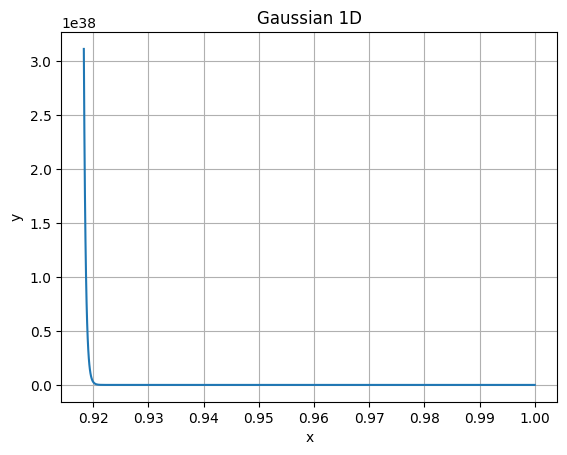

Training done! Time elapsed: 4.93 seconds
Test Loss: nan
-0.51117784
Iteration 5 is running!


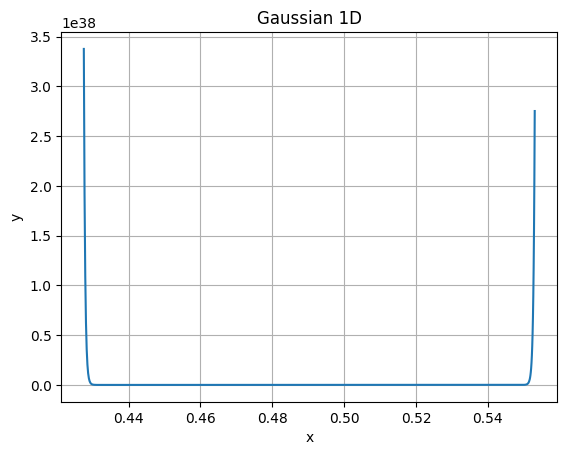

Training done! Time elapsed: 5.34 seconds
Test Loss: nan
-0.51117784
Iteration 6 is running!


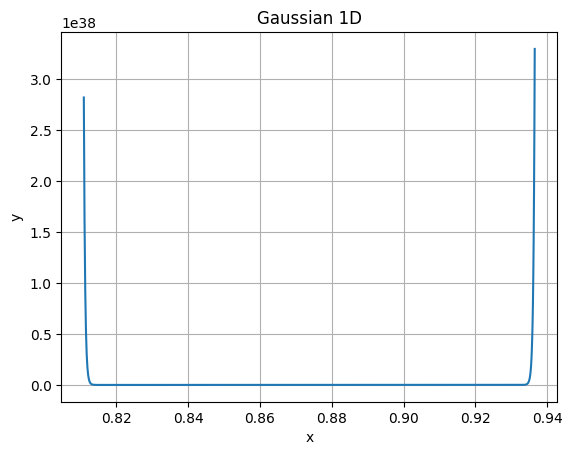

Training done! Time elapsed: 5.09 seconds
Test Loss: nan
-0.51117784
Iteration 7 is running!


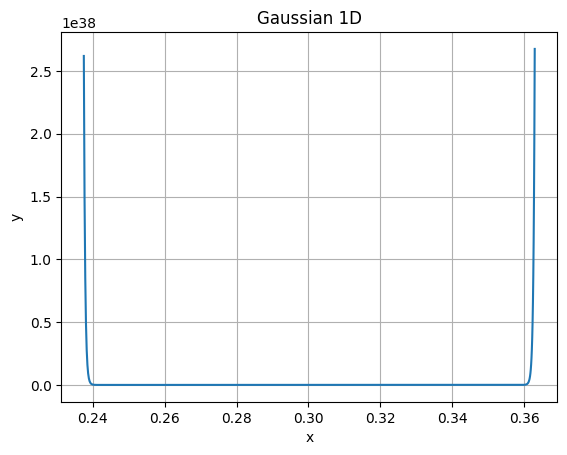

Training done! Time elapsed: 5.01 seconds
Test Loss: nan
-0.51117784
Iteration 8 is running!


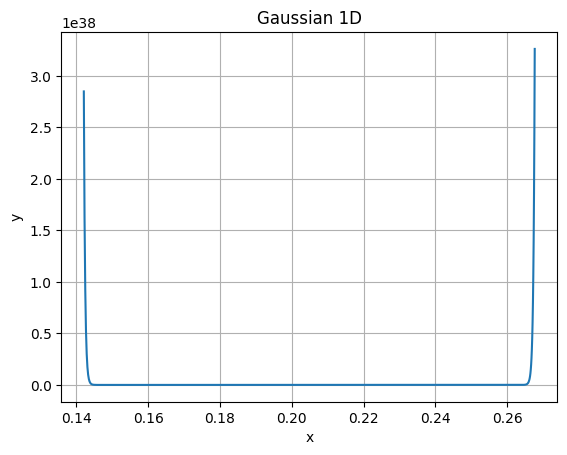

Training done! Time elapsed: 5.03 seconds
Test Loss: nan
-0.51117784
Iteration 9 is running!


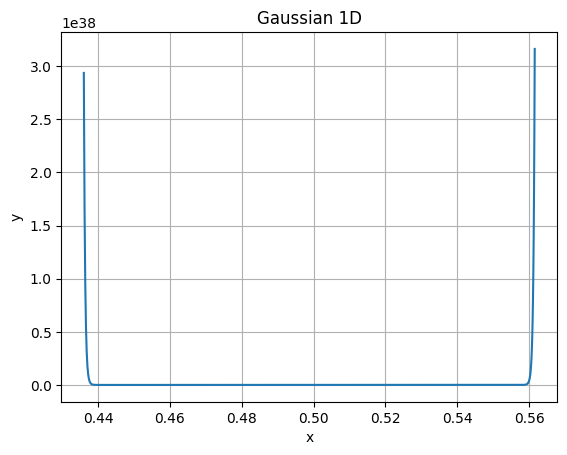

Training done! Time elapsed: 5.05 seconds
Test Loss: nan
-0.51117784
Iteration 10 is running!


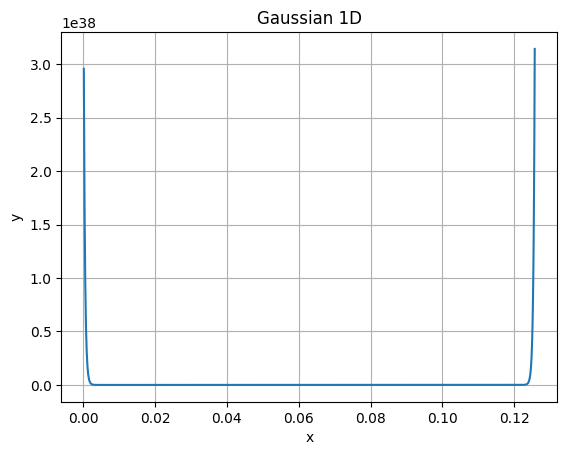

Training done! Time elapsed: 5.21 seconds
Test Loss: nan
-0.51117784


In [80]:
results4 = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results4.append(test_gauss_1d(i, 150))

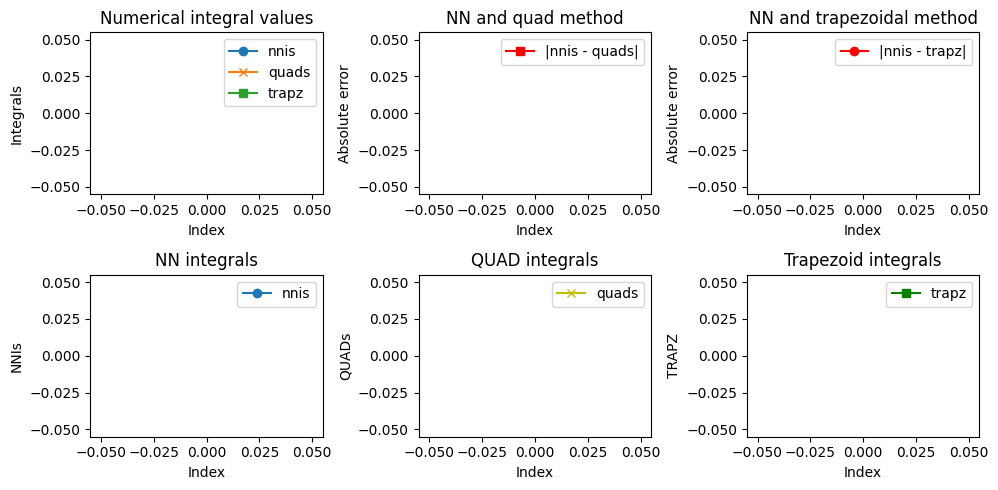

In [81]:
plot_test_results(results4)

# Continuos 1D

In [89]:
def test_cont_1d(index, h):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0.5, 1)
    c = h # * cs

    def cont_1d(X):
        return torch.exp(- c * abs(X - u))

    def cont_1d_float(X):
        return np.exp(- c * abs(X - u))
  
    X, y = generate_data(cont_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Continuos 1D')
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(cont_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = osc_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

Iteration 1 is running!


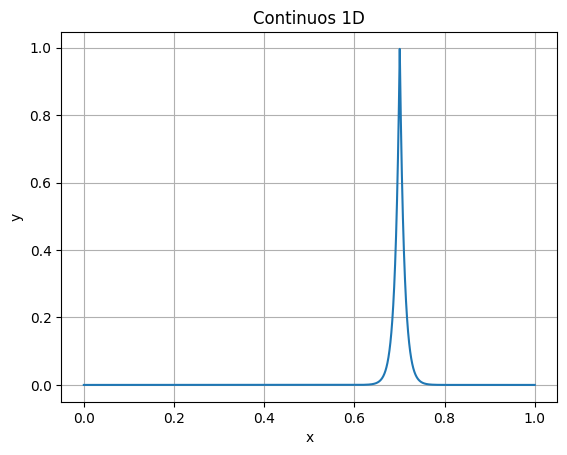

Training done! Time elapsed: 5.94 seconds
Test Loss: 0.0082740113
-0.51117784
Iteration 2 is running!


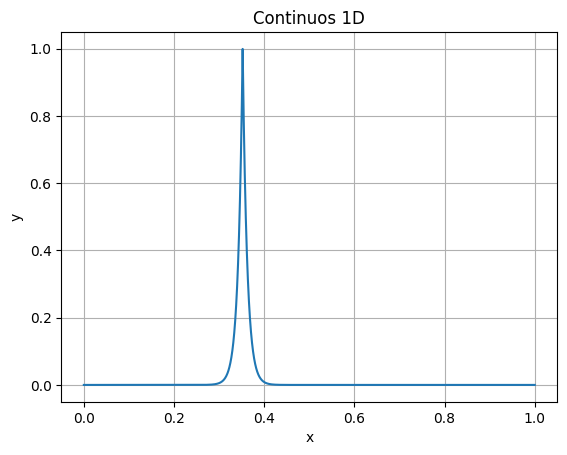

Training done! Time elapsed: 6.01 seconds
Test Loss: 0.0096187275
-0.51117784
Iteration 3 is running!


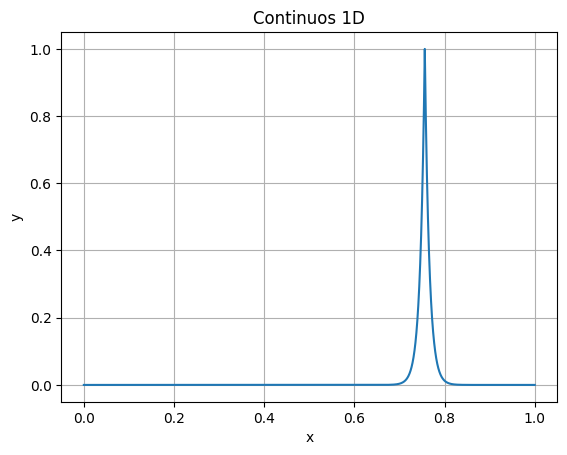

Training done! Time elapsed: 5.99 seconds
Test Loss: 0.0102539333
-0.51117784
Iteration 4 is running!


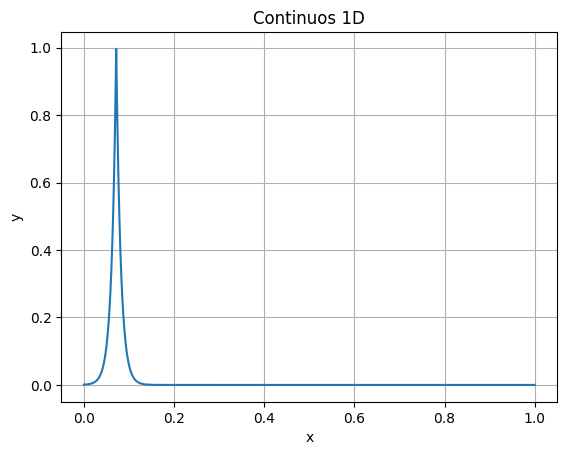

Training done! Time elapsed: 6.04 seconds
Test Loss: 0.0097209318
-0.51117784
Iteration 5 is running!


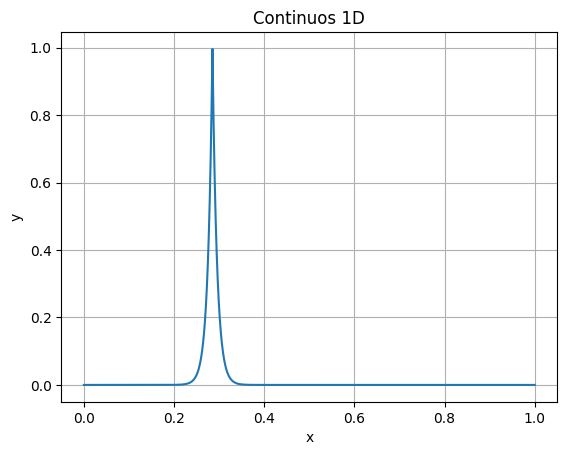

Training done! Time elapsed: 6.01 seconds
Test Loss: 0.0084305545
-0.51117784
Iteration 6 is running!


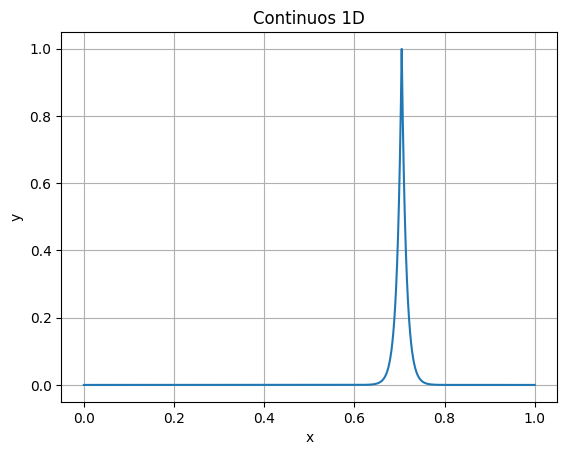

Training done! Time elapsed: 5.78 seconds
Test Loss: 0.0081928400
-0.51117784
Iteration 7 is running!


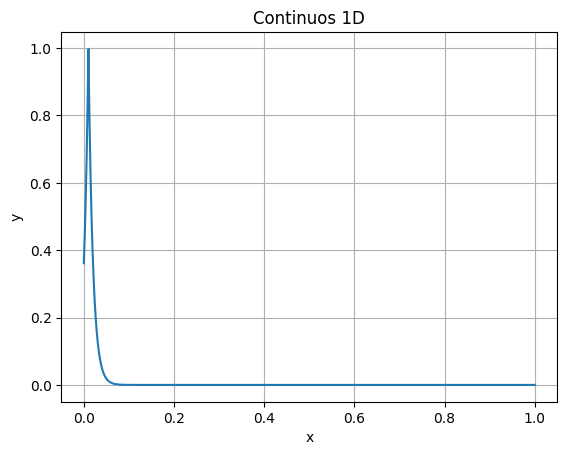

Training done! Time elapsed: 5.70 seconds
Test Loss: 0.0074023074
-0.51117784
Iteration 8 is running!


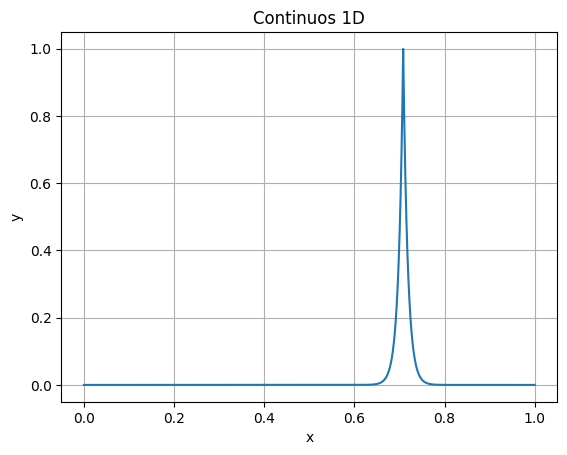

Training done! Time elapsed: 5.62 seconds
Test Loss: 0.0094113061
-0.51117784
Iteration 9 is running!


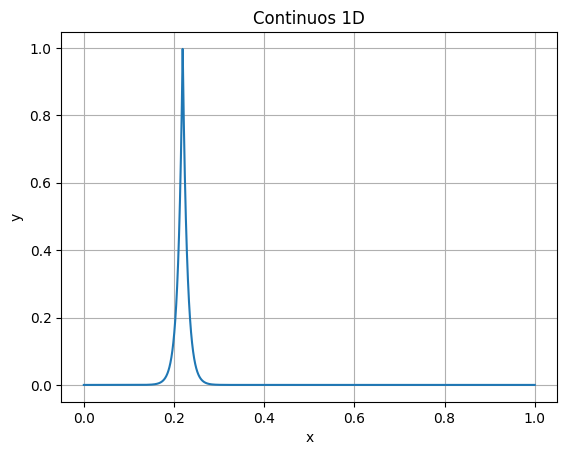

Training done! Time elapsed: 5.55 seconds
Test Loss: 0.0117466208
-0.51117784
Iteration 10 is running!


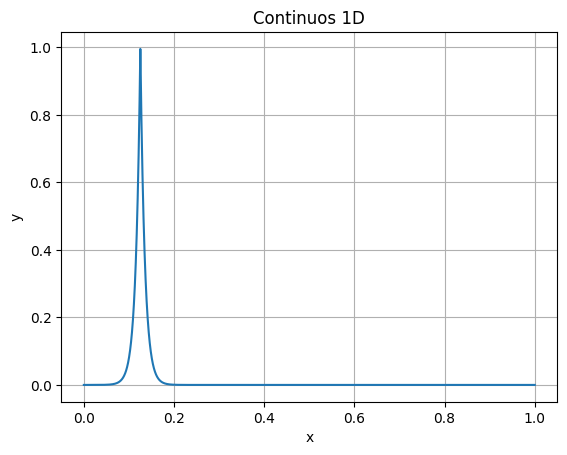

Training done! Time elapsed: 5.62 seconds
Test Loss: 0.0080631878
-0.51117784


In [90]:
results5 = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results5.append(test_cont_1d(i, 100))

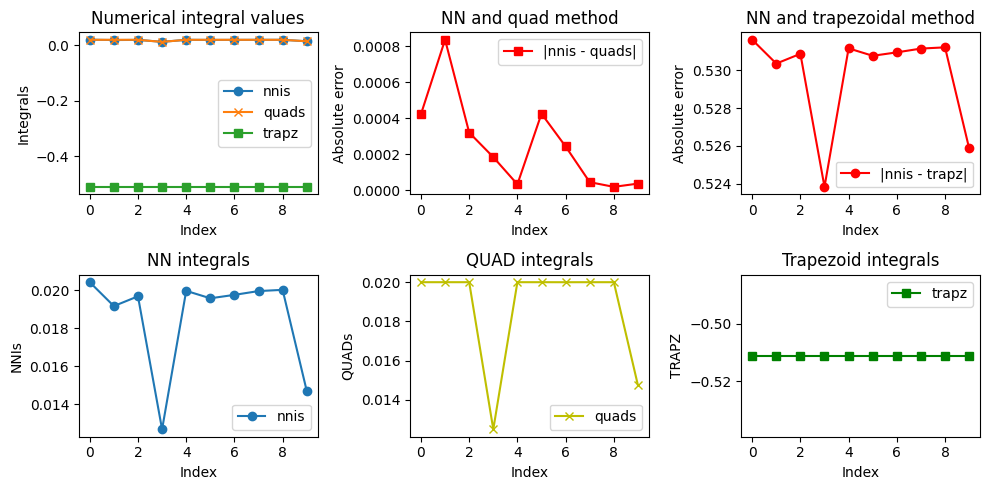

In [88]:
plot_test_results(results5)

# Discontinuous 1D

In [104]:
def test_disk_1d(index, h):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0.5, 1)
    c = h # * cs

    def disk_1d(X):
        y_list = []

        for x in X:
            if x > u:
                y_list.append(0)
            else:
                y_list.append(math.exp(c * x))
        
        return torch.tensor(y_list)

    def disk_1d_float(X):
        if X > u:
            return 0
        else:
            return math.exp(c * X)
          
    X, y = generate_data(disk_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Disontinuos 1D')
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(disk_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = osc_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

Iteration 1 is running!


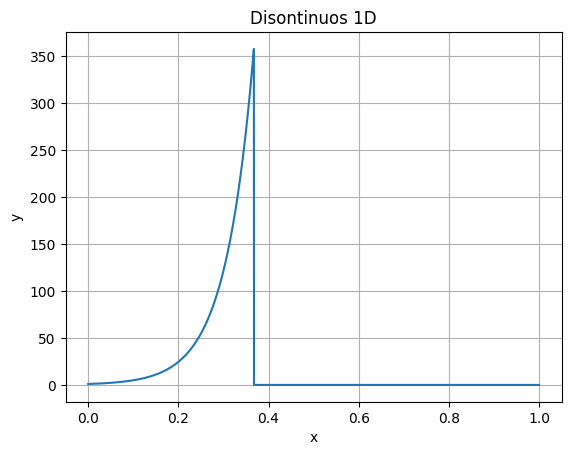

Training done! Time elapsed: 5.56 seconds
Test Loss: 3507.8674316406
-0.51117784
Iteration 2 is running!


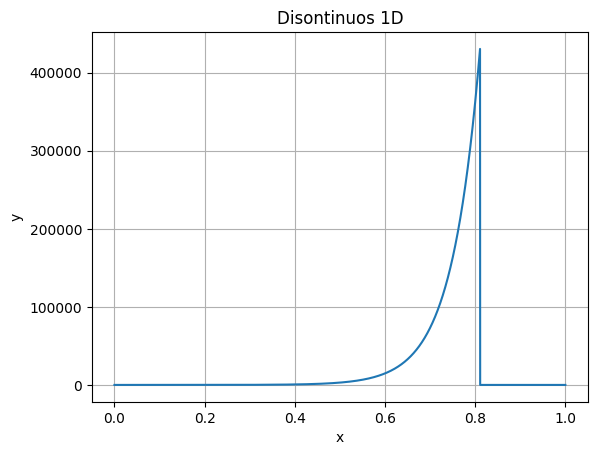

Training done! Time elapsed: 5.59 seconds
Test Loss: 7246288384.0000000000
-0.51117784
Iteration 3 is running!


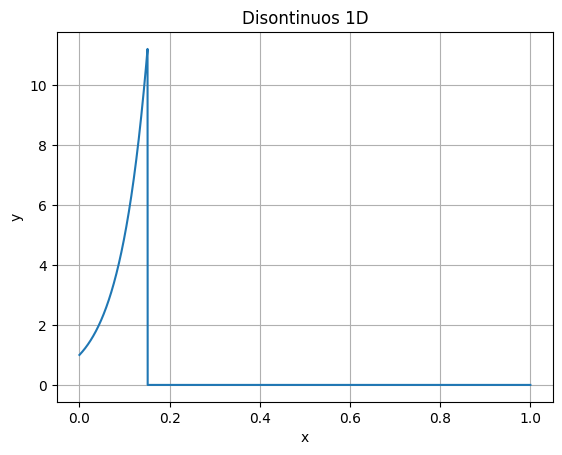

Training done! Time elapsed: 5.66 seconds
Test Loss: 2.6772193909
-0.51117784
Iteration 4 is running!


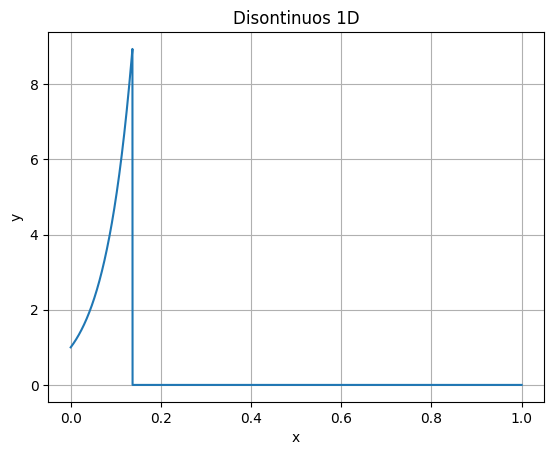

Training done! Time elapsed: 5.46 seconds
Test Loss: 1.4103637934
-0.51117784
Iteration 5 is running!


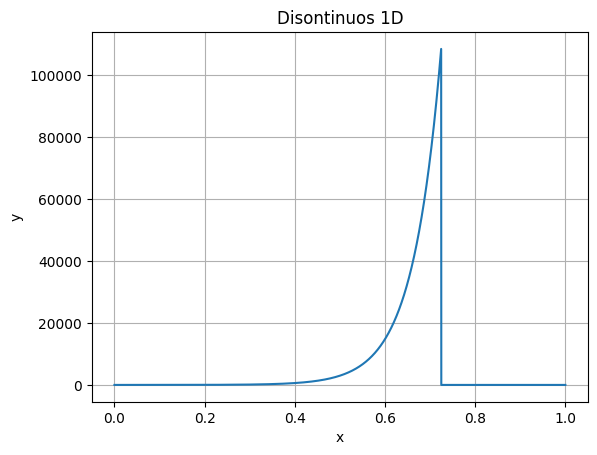

Training done! Time elapsed: 5.43 seconds
Test Loss: 373671520.0000000000
-0.51117784
Iteration 6 is running!


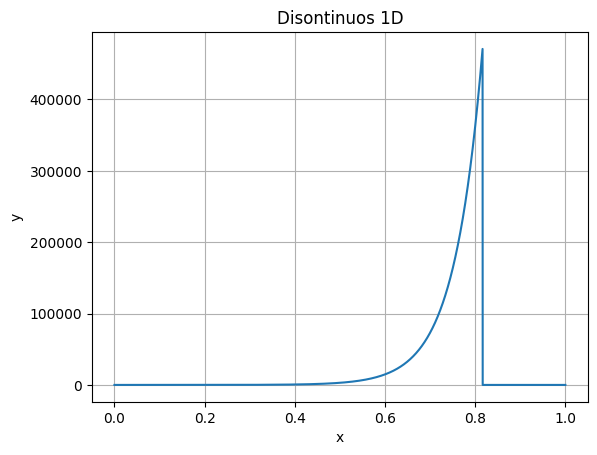

Training done! Time elapsed: 5.47 seconds
Test Loss: 6384070144.0000000000
-0.51117784
Iteration 7 is running!


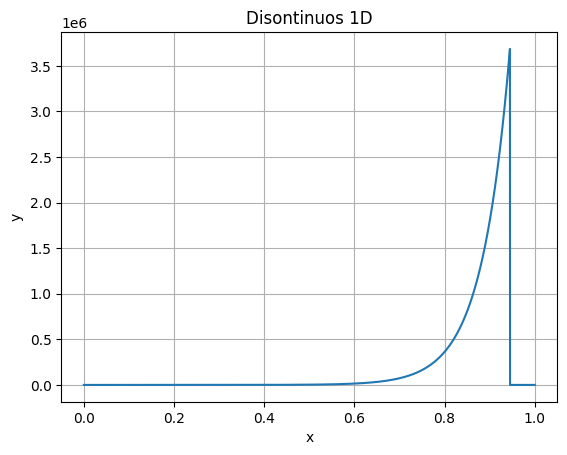

Training done! Time elapsed: 5.33 seconds
Test Loss: 476048916480.0000000000
-0.51117784
Iteration 8 is running!


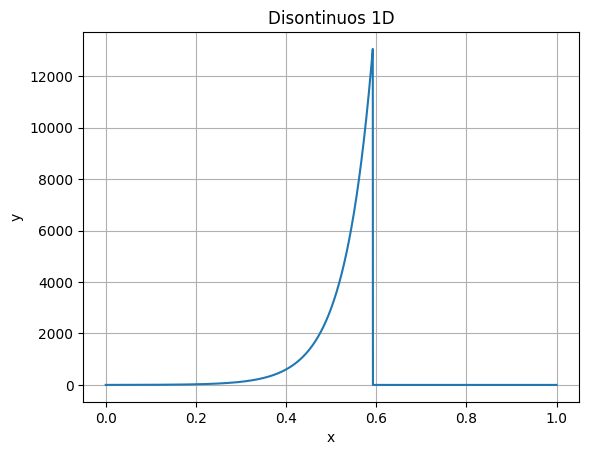

Training done! Time elapsed: 5.24 seconds
Test Loss: 5858459.0000000000
-0.51117784
Iteration 9 is running!


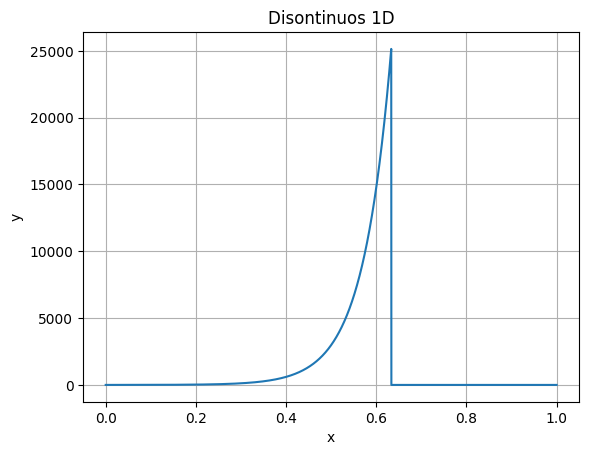

Training done! Time elapsed: 5.58 seconds
Test Loss: 23243570.0000000000
-0.51117784
Iteration 10 is running!


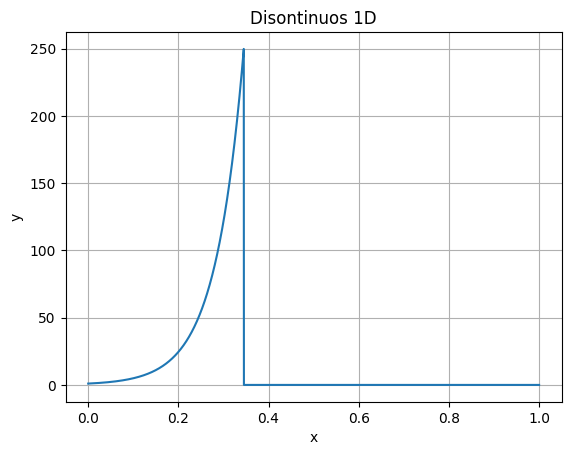

Training done! Time elapsed: 5.55 seconds
Test Loss: 1614.4294433594
-0.51117784


In [105]:
results6 = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results6.append(test_disk_1d(i, 16))

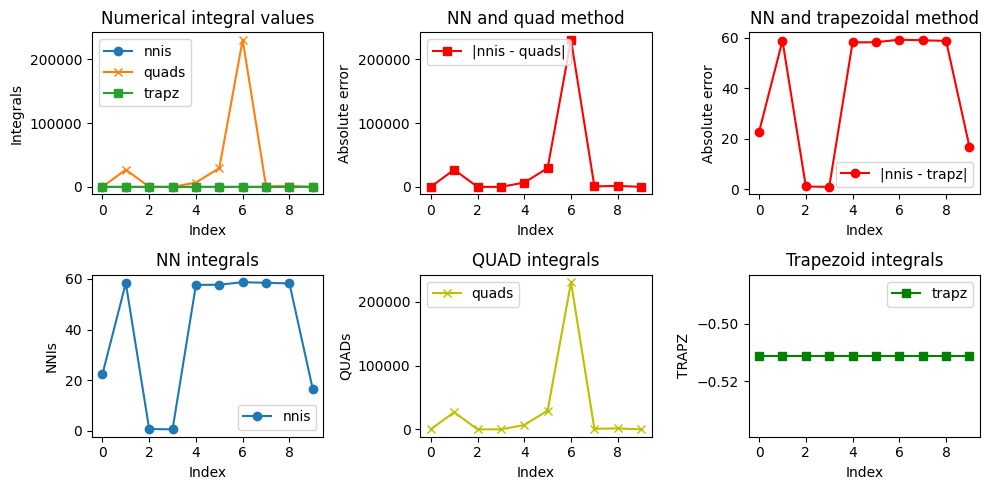

In [106]:
plot_test_results(results6)